In [51]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

from statsmodels.tsa.arima.model import ARIMA

from sklearn.metrics import mean_absolute_error, mean_squared_error

import pickle

In [52]:
df = pd.read_csv('https://breathecode.herokuapp.com/asset/internal-link?id=2546&path=sales.csv')
df

,date,sales
0,2022-09-03 17:10:08.079328,55.292157
1,2022-09-04 17:10:08.079328,53.803211
2,2022-09-05 17:10:08.079328,58.141693
3,2022-09-06 17:10:08.079328,64.530899
4,2022-09-07 17:10:08.079328,66.013633
...,...,...
361,2023-08-30 17:10:08.079328,989.600354
362,2023-08-31 17:10:08.079328,994.987326
363,2023-09-01 17:10:08.079328,995.814415
364,2023-09-02 17:10:08.079328,997.350214


In [53]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 366 entries, 0 to 365
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   date    366 non-null    object 
 1   sales   366 non-null    float64
dtypes: float64(1), object(1)
memory usage: 5.8+ KB


In [54]:
# Convertimos la columna date a tipo datetime, la ordenamos por fecha y establecemos la fecha como índice
df['date'] = pd.to_datetime(df['date'])
df = df.sort_values('date')
df = df.set_index('date')

df

,sales
date,
2022-09-03 17:10:08.079328,55.292157
2022-09-04 17:10:08.079328,53.803211
2022-09-05 17:10:08.079328,58.141693
2022-09-06 17:10:08.079328,64.530899
2022-09-07 17:10:08.079328,66.013633
...,...
2023-08-30 17:10:08.079328,989.600354
2023-08-31 17:10:08.079328,994.987326
2023-09-01 17:10:08.079328,995.814415


In [55]:
# Para saber el tensor
df.index.to_series().diff().mode()

0   1 days
Name: date, dtype: timedelta64[ns]

Observamos que siempre es la misma hora (17:10:08) y las fechas avanzan día a día.

Establecemos como tensor: **1 día**

In [56]:
# Fijamos frecuencia diaria:

df = df.asfreq('D')

# Limpiamos y dejamos solo la fecha:

df.index = df.index.normalize()

df.head()

,sales
date,
2022-09-03,55.292157
2022-09-04,53.803211
2022-09-05,58.141693
2022-09-06,64.530899
2022-09-07,66.013633


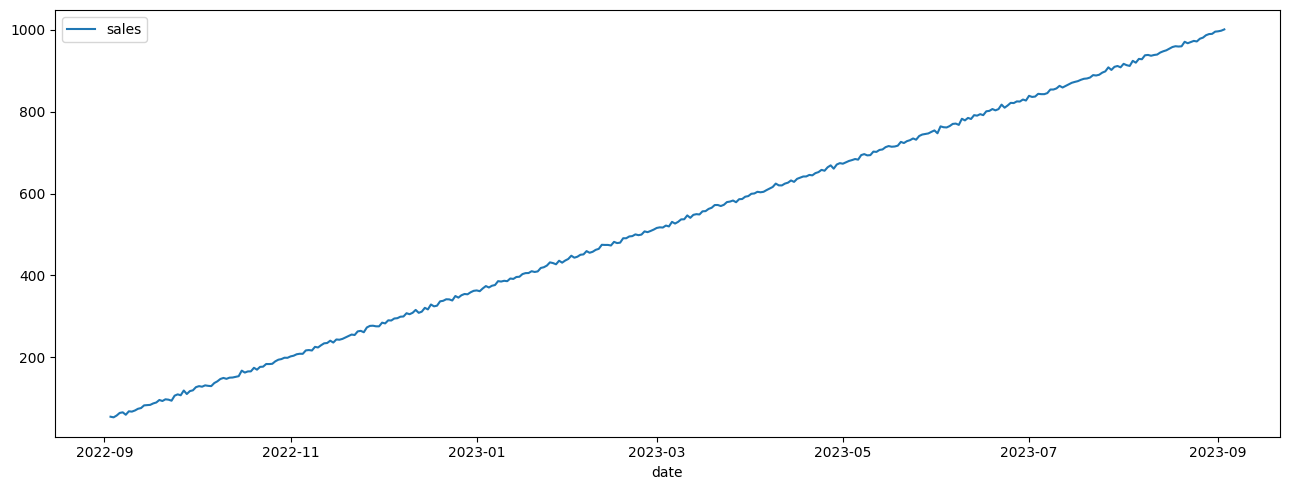

In [57]:
# Graficamos
fig, axis = plt.subplots(figsize = (13, 5))

sns.lineplot(data = df)

plt.tight_layout()

plt.show()

Observamos que la tendencia es creciente con el tiempo

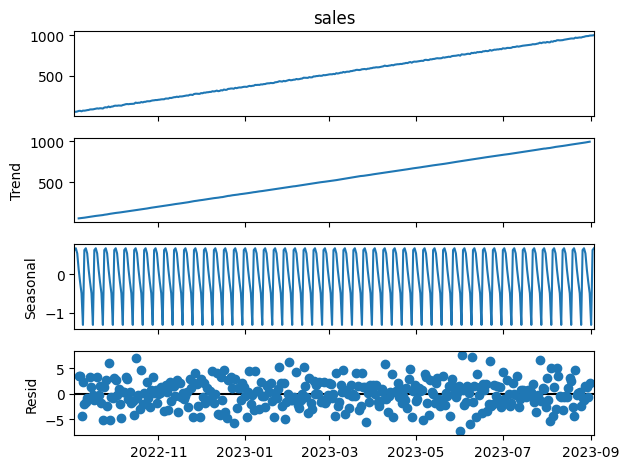

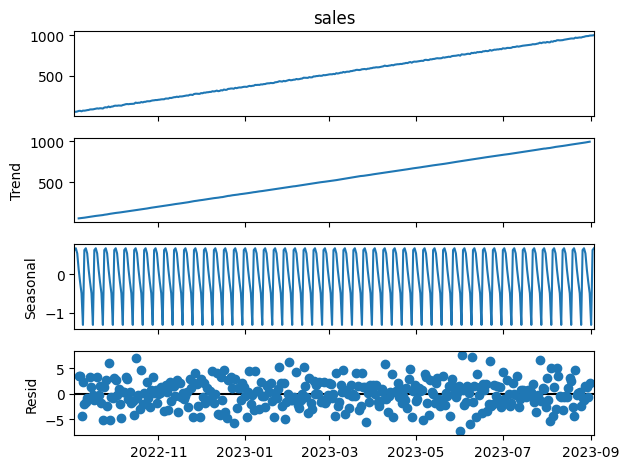

In [58]:
# Descomponemos la serie temporal
decomposition = seasonal_decompose(df['sales'], period=7)
decomposition.plot()

#### Análisis de la tendencia

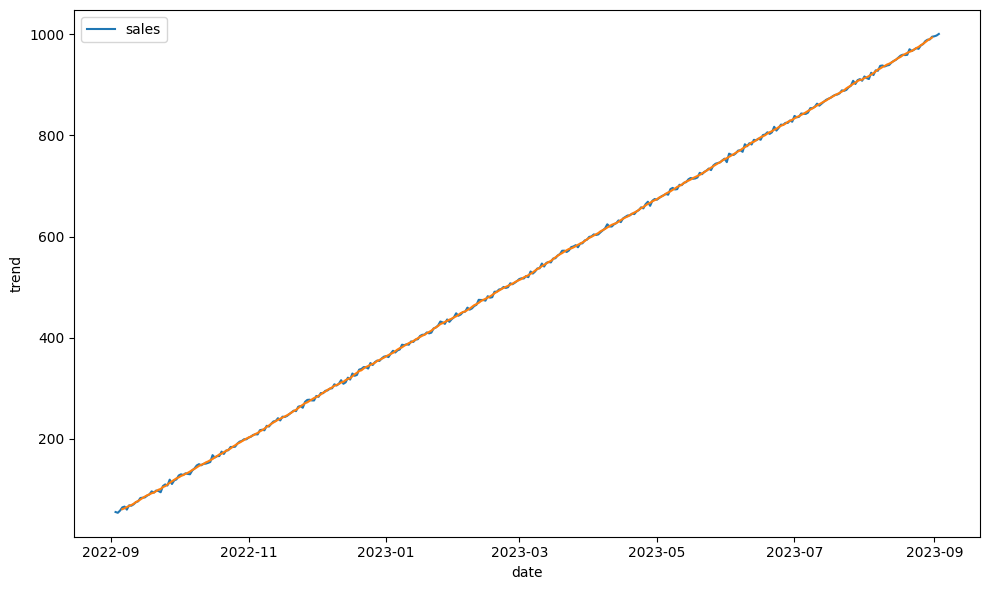

In [59]:
trend = decomposition.trend

fig, axis = plt.subplots(figsize = (10, 6))

sns.lineplot(data=df)
sns.lineplot(data = trend)

plt.tight_layout()

plt.show()

Se confirma lo observado: una clara tendencia positiva a lo largo de los meses.

Hay un aumento general en el número de ventas a lo largo del tiempo.

#### Análisis de la estacionalidad

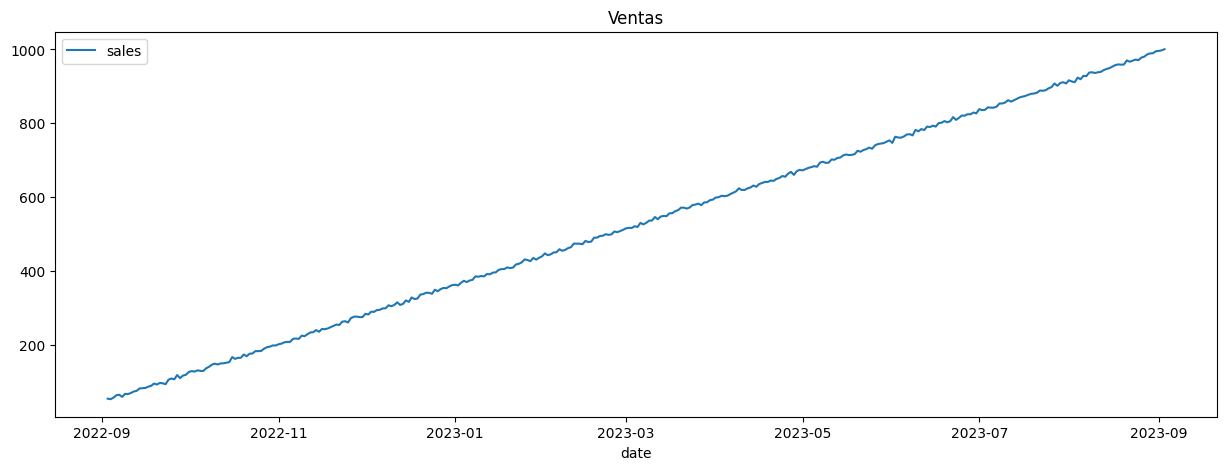

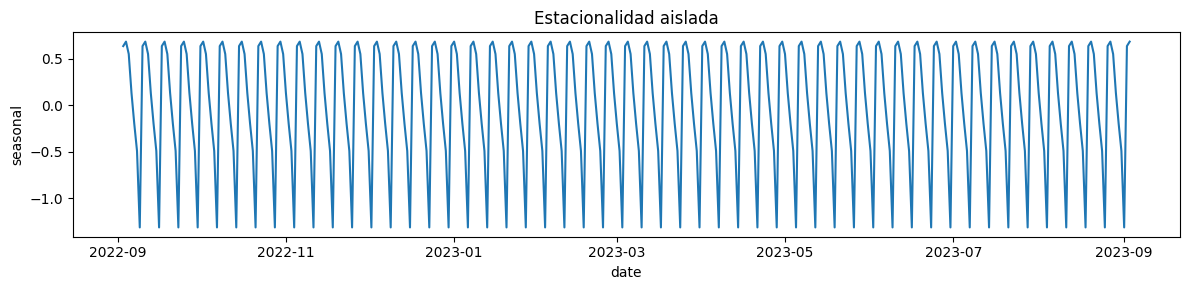

In [60]:
seasonal = decomposition.seasonal

plt.figure(figsize = (15, 5))

sns.lineplot(data = df) 
plt.title('Ventas')

plt.figure(figsize = (12, 3))
sns.lineplot(data = seasonal)
plt.title('Estacionalidad aislada')

plt.tight_layout()

plt.show()

La estacionalidad semanal muestra un patrón repetitivo que se repite cada 7 días. Se observa que las ventas tienden a aumentar durante los primeros días de la semana, alcanzando un pico a mitad de semana, mientras que los fines de semana presentan el nivel mínimo de ventas. 

#### Análisis de Estacionariedad

In [61]:
def test_stationarity(timeseries):
    print("Resultados de la prueba de Dickey-Fuller:")
    dftest = adfuller(timeseries, autolag = "AIC")
    dfoutput = pd.Series(dftest[0:4], index = ["Test Statistic", "p-value", "#Lags Used", "Number of Observations Used"])
    for key,value in dftest[4].items():
        dfoutput["Critical Value (%s)"%key] = value
    return dfoutput

test_stationarity(df)

Resultados de la prueba de Dickey-Fuller:


Test Statistic                   0.545414
p-value                          0.986190
#Lags Used                      13.000000
Number of Observations Used    352.000000
Critical Value (1%)             -3.449065
Critical Value (5%)             -2.869786
Critical Value (10%)            -2.571163
dtype: float64

El test de Dickey-Fuller nos indica que el p-valor es mayor a 0.05 y por tanto no podemos afirmar que la seria tenga estacionariedad. Esto puede deberse a una tendencia creciente muy fuerte.

In [62]:
# Diferenciar la serie para remover tendencia y mejorar la estacionariedad

df['sales_dif'] = df['sales'].diff()
df.dropna(inplace=True)     #elimina el primer NaN
df

,sales,sales_dif
date,,
2022-09-04,53.803211,-1.488946
2022-09-05,58.141693,4.338482
2022-09-06,64.530899,6.389205
2022-09-07,66.013633,1.482734
2022-09-08,60.081865,-5.931768
...,...,...
2023-08-30,989.600354,0.518681
2023-08-31,994.987326,5.386972
2023-09-01,995.814415,0.827090


In [63]:
test_stationarity(df['sales_dif'])

Resultados de la prueba de Dickey-Fuller:


Test Statistic                -9.430263e+00
p-value                        5.212954e-16
#Lags Used                     1.200000e+01
Number of Observations Used    3.520000e+02
Critical Value (1%)           -3.449065e+00
Critical Value (5%)           -2.869786e+00
Critical Value (10%)          -2.571163e+00
dtype: float64

Despues de eliminar la tendencia, el test de Dickey-Fuller da como p-valor 5.21e-16 < 0.05, lo que significa que la serie sales_dif sí es estacionaria

#### Análisis de residuos

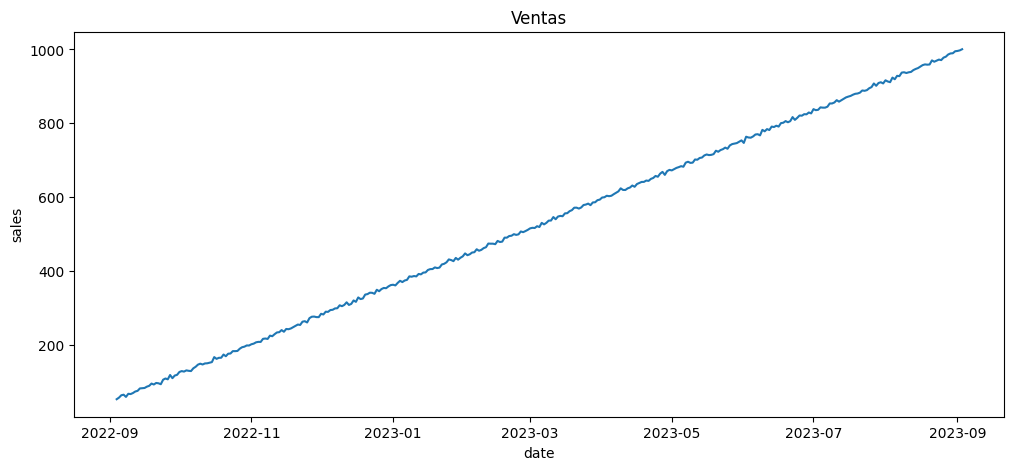

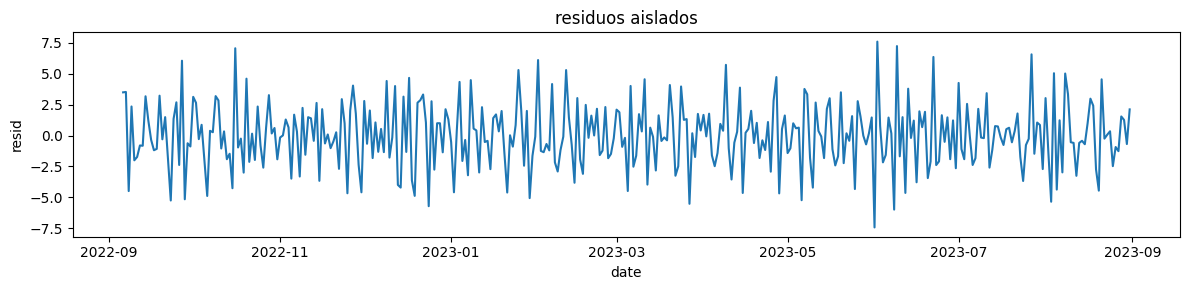

In [75]:
residual = decomposition.resid

plt.figure(figsize = (12, 5))

sns.lineplot(data = df['sales']) 
plt.title('Ventas')

plt.figure(figsize = (12, 3))
sns.lineplot(data = residual)
plt.title('residuos aislados')

plt.tight_layout()

plt.show()

Los residuos están uniformemente dispersos alrededor de cero sin un patrón claro, indicando que la descomposición fue adecuada

ARIMA

In [65]:
train_size = int(len(df) * 0.8)

train = df['sales'].iloc[:train_size]
test  = df['sales'].iloc[train_size:]

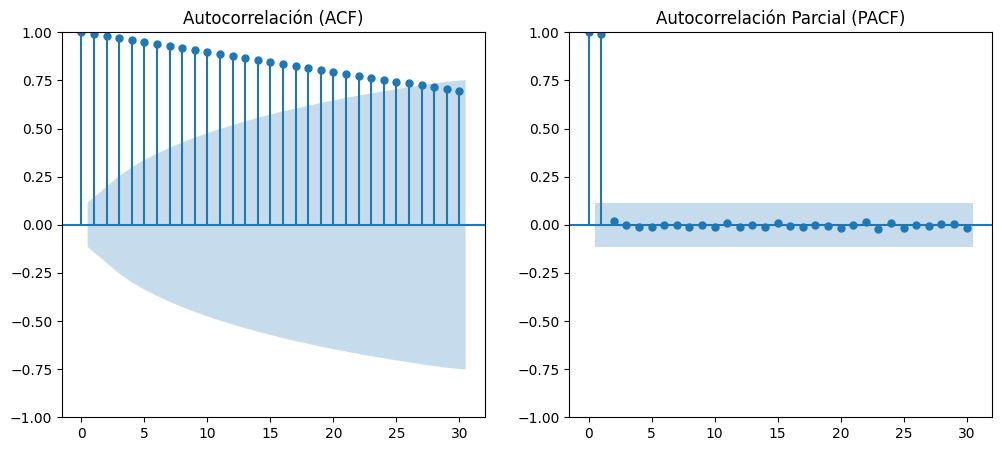

In [66]:
fig, ax = plt.subplots(1, 2, figsize=(12, 5))

# ACF para determinar q
plot_acf(train, lags=30, ax=ax[0])
ax[0].set_title("Autocorrelación (ACF)")

# PACF para determinar p
plot_pacf(train, lags=30, ax=ax[1])
ax[1].set_title("Autocorrelación Parcial (PACF)")

plt.show()

In [67]:
p = 1
d = 1
q = 1

modelo_arima = ARIMA(train, order=(p,d,q))

resultado_arima = modelo_arima.fit()

/home/vscode/.local/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [68]:
# Predicciones del conjunto de test
predicciones = resultado_arima.predict(start=len(train), end=len(df)-1)
predicciones

2023-06-23     819.509850
2023-06-24     822.107950
2023-06-25     824.706048
2023-06-26     827.304147
2023-06-27     829.902244
                 ...     
2023-08-30     996.179180
2023-08-31     998.777236
2023-09-01    1001.375293
2023-09-02    1003.973348
2023-09-03    1006.571403
Freq: D, Name: predicted_mean, Length: 73, dtype: float64

In [69]:
# Métricas
mae = mean_absolute_error(test, predicciones)
rmse = np.sqrt(mean_squared_error(test, predicciones))
print("MAE:", mae)
print("RMSE:", rmse)

MAE: 7.235826963334268
RMSE: 7.710557425751433


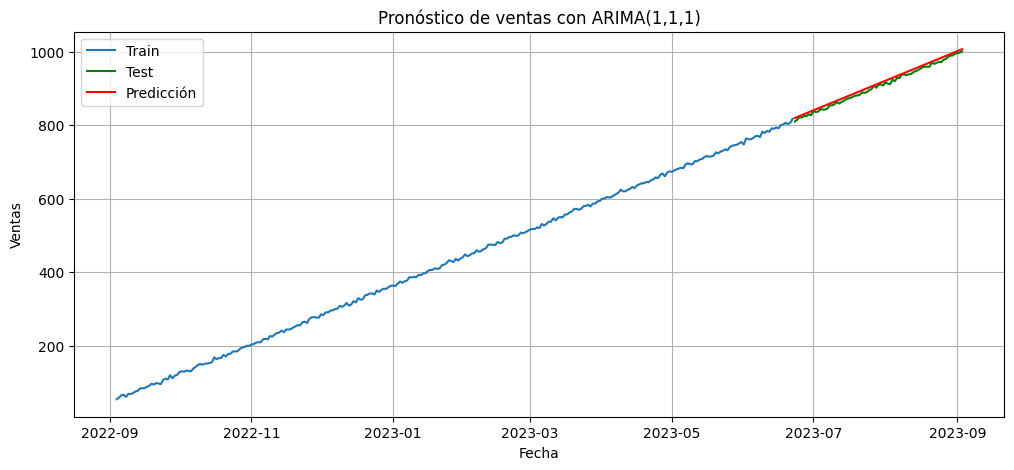

In [70]:
# Graficar pronóstico
plt.figure(figsize=(12,5))
plt.plot(train, label='Train')
plt.plot(test, label='Test', color = 'green')
plt.plot(predicciones.index, predicciones, label='Predicción', color='red')
plt.title("Pronóstico de ventas con ARIMA(1,1,1)")
plt.xlabel("Fecha")
plt.ylabel("Ventas")
plt.legend()
plt.grid(True)
plt.show()

Primero entrenamos un modelo ARIMA(1,1,1) sobre la serie de ventas diaria. Este modelo captura la tendencia creciente y las correlaciones a corto plazo, pero no incorpora explícitamente la estacionalidad semanal

Dado que la serie presenta una estacionalidad semanal, se entrenó un modelo SARIMA(1,1,1)x(1,1,1,7)

#### Modelo SARIMA (seasonal)

In [71]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Modelo SARIMA
modelo_sarima = SARIMAX(
    train,
    order=(1,1,1),          
    seasonal_order=(1,1,1,7) 
)

resultado_sarima = modelo_sarima.fit()

# Predicciones del conjunto de test
pred = resultado_sarima.predict(start=len(train), end=len(df)-1)

In [72]:
# Métricas
mae = mean_absolute_error(test, pred)
rmse = np.sqrt(mean_squared_error(test, pred))
print("MAE:", mae)
print("RMSE:", rmse)

MAE: 2.451508109518906
RMSE: 2.943815434936791


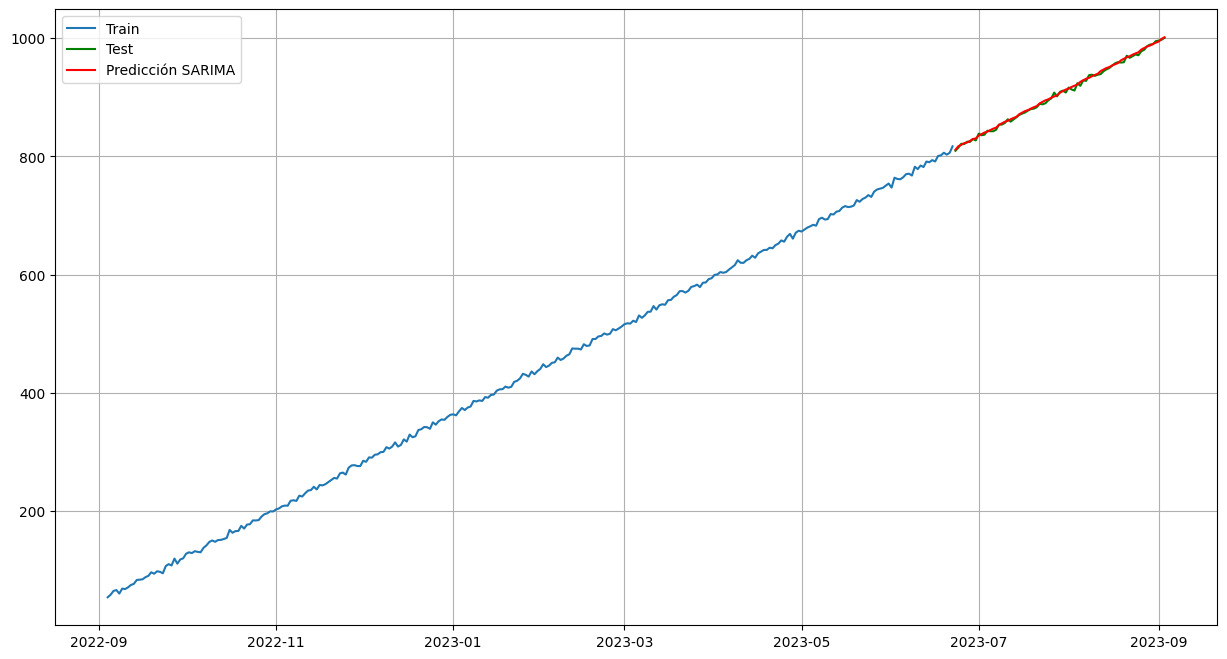

In [73]:
plt.figure(figsize=(15,8))
plt.plot(train, label='Train')
plt.plot(test, label='Test', color = 'green')
plt.plot(pred, label='Predicción SARIMA', color='red')
plt.legend()
plt.grid(True)
plt.show()

Este modelo captura tanto la tendencia creciente como los patrones semanales de subidas y bajadas de ventas

Comparando ambos modelos, se observa que SARIMA proporciona predicciones mucho más precisas que ARIMA, como se refleja en la reducción de MAE y RMSE. Esto prueba que incluir la estacionalidad mejora el desempeño del modelo para la predicción de ventas

In [74]:

# Guardar el modelo
with open("../models/ARIMA.sav", "wb") as f:
    pickle.dump(modelo_arima, f)

with open("../models/SARIMA.sav", "wb") as f:
    pickle.dump(modelo_sarima, f)